In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    ToTensorImage,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

from torchsummary import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_cells = 256  # number of cells in each layer
lr = 3e-4
max_grad_norm = 1.0

In [3]:
frame_skip = 1
frames_per_batch = 1000 // frame_skip
total_frames = 10_000 // frame_skip

In [4]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimisation steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

In [5]:
base_env = GymEnv("CarRacing-v2", device=device, frame_skip=frame_skip)

base_env = TransformedEnv(
    base_env,
    Compose(
        DoubleToFloat(in_keys=["pixels"]),
        ToTensorImage(in_keys=["pixels"]),
        StepCounter(),
    ),
)

In [6]:
print("Observation spec:", base_env.observation_spec)
print("Action spec:", base_env.action_spec)
print("Reward spec:", base_env.reward_spec)
print("Input spec:", base_env.input_spec)

Observation spec: CompositeSpec(
    pixels: BoundedTensorSpec(
         shape=torch.Size([3, 96, 96]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([3, 96, 96]), device=cpu, dtype=torch.float32, contiguous=False), maximum=Tensor(shape=torch.Size([3, 96, 96]), device=cpu, dtype=torch.float32, contiguous=False)), device=cpu, dtype=torch.float32, domain=continuous),
    step_count: UnboundedDiscreteTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True), maximum=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True)), device=cpu, dtype=torch.int64, domain=continuous), device=cpu, shape=torch.Size([]))
Action spec: BoundedTensorSpec(
     shape=torch.Size([3]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.float32, contiguous=True), maximum=Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.float32, contiguous=True)), device=cpu

In [15]:
rollout = base_env.rollout(1)
print("Rollout spec:", rollout)
print("Shape of the rollout:", rollout.batch_size)

Rollout spec: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                pixels: Tensor(shape=torch.Size([1, 3, 96, 96]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([1]),
            device=cpu,
            is_shared=False),
        pixels: Tensor(shape=torch.Size([1, 3, 96, 96]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.in

In [23]:
actor_net = nn.Sequential(
    nn.Conv2d(3, 1, kernel_size=4, stride=2, device=device),
    nn.Flatten(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * base_env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

policy_module = TensorDictModule(
    actor_net, in_keys=["pixels"], out_keys=["loc", "scale"]
)

policy_module = ProbabilisticActor(
    module=policy_module,
    spec=base_env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": base_env.action_spec.space.minimum,
        "max": base_env.action_spec.space.maximum,
    },
    return_log_prob=True,
)

summary(actor_net, input_size=(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 47, 47]              49
           Flatten-2                 [-1, 2209]               0
            Linear-3                  [-1, 256]         565,760
              Tanh-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          65,792
              Tanh-6                  [-1, 256]               0
            Linear-7                  [-1, 256]          65,792
              Tanh-8                  [-1, 256]               0
            Linear-9                    [-1, 6]           1,542
NormalParamExtractor-10         [[-1, 3], [-1, 3]]               0
Total params: 698,935
Trainable params: 698,935
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.05
Params size (MB): 2.67
Estimate

In [24]:
value_network = nn.Sequential(
    nn.Conv2d(3, 1, kernel_size=4, stride=2, device=device),
    nn.Flatten(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(value_network, in_keys=["pixels"])

summary(value_network, input_size=(3,96,96,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 47, 47]              49
           Flatten-2                 [-1, 2209]               0
            Linear-3                  [-1, 256]         565,760
              Tanh-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          65,792
              Tanh-6                  [-1, 256]               0
            Linear-7                  [-1, 256]          65,792
              Tanh-8                  [-1, 256]               0
            Linear-9                    [-1, 1]             257
Total params: 697,650
Trainable params: 697,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.05
Params size (MB): 2.66
Estimated Total Size (MB): 2.81
-------------------------------------------

In [25]:
print("Running policy:", policy_module(base_env.reset()))
print("Running value:", value_module(base_env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([1, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        pixels: Tensor(shape=torch.Size([3, 96, 96]), device=cpu, dtype=torch.float32, is_shared=False),
        sample_log_prob: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        scale: Tensor(shape=torch.Size([1, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        pixels: Tensor(shape=torch.Size([3, 96, 96]), device

In [38]:
collector = SyncDataCollector(
    base_env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

In [27]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

In [34]:
advantage_module = GAE(gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_frames // frames_per_batch, 0.0)

In [39]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

for i, tensordict_data in enumerate(collector):
    for _ in range(num_epochs):
        with torch.no_grad():
            advantage_module(tensordict_data)
        
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_entropy"]
                + loss_vals["loss_critic"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()
    
    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)

    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )

    logs["step_count"].append(tensordict_data["step_count"].max().item())
    step_count_str = f"step count(max): {logs['step_count'][-1]}"

    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"

    if i % 10 == 0:
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            eval_rollout = base_env.rollout(1000, policy_module)
            logs["eval_reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward(sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval_step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward={logs['eval reward(sum)'][-1]: 4.4f} "
                f"init={logs['eval reward(sum)'][0]: 4.4f} "
                f"eval step count(max): {logs['eval_step_count'][-1]}"
            )

            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, step_count_str, lr_str]))
    scheduler.step()

  0%|          | 0/10000 [01:20<?, ?it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1

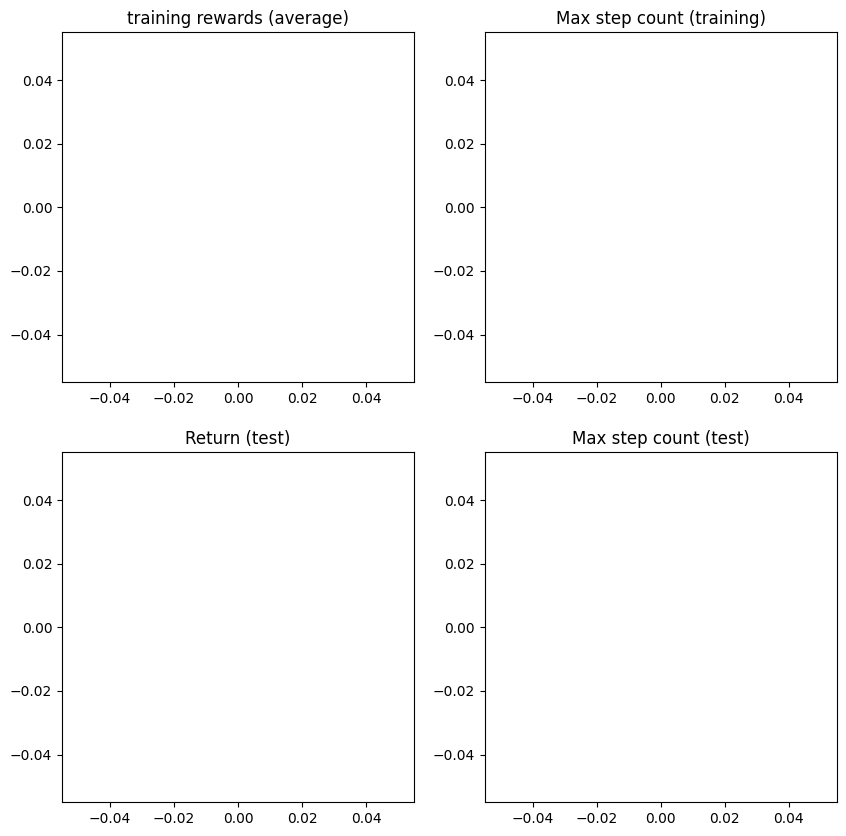

In [20]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()